# Demo project

In [2]:
%pip install pandas numpy statsmodels scikit-learn shap matplotlib altair


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Generate clinical and genetic features to test and save them for the record

In [24]:
#%pip install pandas 
import pandas as pd
import numpy as np

# Define gene list and feature types
genes = [
    "APC", "ATM", "AXIN2", "BAP1", "BARD1", "BMPR1A", "BRCA1", "BRCA2", "BRIP1",
    "CDH1", "CDK4", "CDKN2A", "CDKN2B", "CDKN1B", "CHECK2", "CTNNA1", "DICER1",
    "EPCAN", "FH", "FLCN", "GREM1", "HOXB13", "KIT", "MAX", "MEN1", "MET", "MITF",
    "MLH", "MSH2", "MSH3", "MSH6", "MUTYH", "NF1", "NTHL1", "PALB2", "PDGFRQ",
    "PMS2", "POLD1", "POLE", "PTEN", "PTCH1", "RAD51C", "RAD51D", "RED", "SDHA",
    "SDHAF2", "SDHB", "SDHC", "SDHD", "SMAD4", "STK11", "TMEM127", "TP53", "TSC2", "VHL"
]

# Create random test data for genomic features
num_samples = 100
genomic_data = {
    f"{gene}_exp": np.random.randint(0, 2, num_samples) for gene in genes
}
genomic_data.update({
    f"{gene}_cn": np.random.randint(0, 2, num_samples) for gene in genes
})
genomic_data.update({
    f"{gene}": np.random.randint(0, 2, num_samples) for gene in genes
})
genomic_features = pd.DataFrame(genomic_data)

# Create random test data for clinical features
clinical_features = pd.DataFrame({
    f"lab_test_{i}": np.random.randint(0, 2, num_samples) for i in range(1, 21)
})

# Add a random binary target for testing
genomic_features['target_column'] = np.random.randint(0, 2, num_samples)

#save the generated features
genomic_features.to_csv('./data/genomic_features.csv')
clinical_features.to_csv('./data/clinical_features.csv')


## Load data and prepare the feature matrix. It is a good idea to QC your features before using them as input, check key distributions, test for bias and data drift

In [25]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load your data
genomic_features = pd.read_csv('./data/genomic_features.csv')
clinical_features = pd.read_csv('./data/clinical_features.csv')
# Combine the datasets
data = pd.concat([genomic_features, clinical_features], axis=1)

# Define target variable and features
# Replace 'target_feature' with the name of the target column
target_feature = 'target_column'  # Change this
X = data.drop(columns=[target_feature])
y = data[target_feature]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [26]:
# Train a model (Random Forest)
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

## Plot SHAP plot. 
### Since a random forest is essentially an ensemble of decision trees, SHAP’s TreeExplainer can leverage the tree structure to calculate Shapley values more quickly and accurately than generic approaches (like the KernelExplainer)

SHAP values for class 1 shape: (30, 187)
X_test shape: (30, 187)


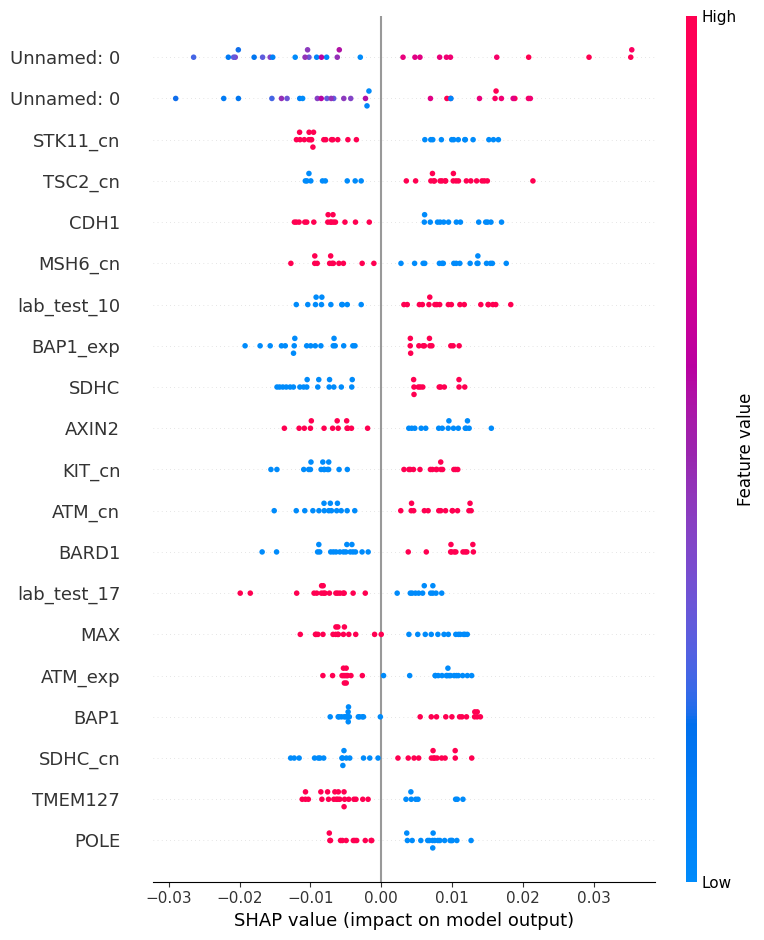

In [27]:
# Extract SHAP values for class 1 directly
shap_values_class_1 = shap_values[:, :, 1]  # Extract class 1 values

# Check the shapes
print("SHAP values for class 1 shape:", shap_values_class_1.shape)
print("X_test shape:", X_test.shape)

# Ensure shapes match
assert shap_values_class_1.shape == X_test.shape, "SHAP values shape does not match X_test shape"

# Plot SHAP summary for class 1
shap.summary_plot(shap_values_class_1, X_test)


## Calculate VIF (for logistic regression)

In [28]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X):
    """Calculate VIF for each feature in the dataset."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_results = compute_vif(X)

# Display features with VIF < 10
vif_results_below_10 = vif_results[vif_results['VIF'] < 10]
print(vif_results_below_10)

/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Empty DataFrame
Columns: [Feature, VIF]
Index: []


## Calculate correlation matrix, drop highly correlated features

In [30]:
# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
X = X.drop(columns=to_drop)

print(f"Removed features due to high correlation: {to_drop}")


Removed features due to high correlation: []


## Check that the target column is binary and recalculate VIF

In [31]:
# Ensure target column is binary (e.g., values 0 and 1)
print(f"Unique values in the target column: {y.unique()}")


Unique values in the target column: [0 1]


#Perform WALD test

In [32]:
# Recalculate VIF
vif_results = compute_vif(X)
print(vif_results)

# Refit the logistic regression model
X = sm.add_constant(X)  # Add intercept
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Perform Wald's test
wald_results = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": result.params,
    "Std Err": result.bse,
    "z-Score": result.tvalues,
    "p-Value": result.pvalues
})

print(wald_results)


/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         Feature  VIF
0        APC_exp  inf
1        ATM_exp  inf
2      AXIN2_exp  inf
3       BAP1_exp  inf
4      BARD1_exp  inf
..           ...  ...
180  lab_test_16  inf
181  lab_test_17  inf
182  lab_test_18  inf
183  lab_test_19  inf
184  lab_test_20  inf

[185 rows x 2 columns]
         Current function value: inf
         Iterations: 35


/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/olemar/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

## Apply L2 regularization

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Apply L2 regularization
linear_reg = LogisticRegression(penalty='l2', solver='liblinear')
linear_reg.fit(X_train, y_train)

# Check coefficients and perform significance testing
print(f"Coefficients: {linear_reg.coef_}")


Coefficients: [[ 0.00961356 -0.39929412 -0.23337981  0.06606189  0.53438205  0.00975028
  -0.12271784  0.11669386  0.37257436  0.14395528 -0.20375179  0.29118676
   0.13232236 -0.24125671 -0.11377614  0.20659851 -0.21044055 -0.04330794
  -0.15210654 -0.0807435  -0.17991538 -0.07981568 -0.09916297  0.24215135
  -0.34915365 -0.17972401 -0.12773935  0.28885088  0.12900034 -0.30368036
   0.23252027  0.01016824  0.45221015 -0.13110834  0.02459715 -0.12047775
  -0.22363898 -0.03958238  0.14254843 -0.34436996 -0.22949076 -0.29566985
   0.18888611  0.46904302  0.18089215 -0.27428196  0.28630189  0.30653103
   0.0136471   0.30985655 -0.01785105 -0.10555342 -0.21762438 -0.07612947
  -0.30485067 -0.18900352  0.33979156  0.43419713  0.16764738  0.27909556
  -0.09145518 -0.18490528 -0.12308855 -0.26141245  0.08123309  0.18850563
   0.05736973  0.27439656 -0.04427898  0.00117448  0.22300676  0.02593037
  -0.01550889 -0.37226682  0.07932936 -0.16428008 -0.02830962 -0.03734089
   0.76641932  0.1421227

## Train ElasticNet model (Lasso and Ridge Regression)

In [34]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data into train and test sets

# Apply Elastic Net with Cross-Validation to find the best alpha and L1 ratio
elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9],  # Mix of L1 (LASSO) and L2 (ridge)
                           alphas=[0.1, 0.01, 0.001],  # Regularization strengths
                           cv=6,                       # 5-fold cross-validation
                           random_state=1248)

# Fit the model
elastic_net.fit(X_train, y_train)

# Display the best alpha and l1_ratio
print("Optimal alpha:", elastic_net.alpha_)
print("Optimal L1 ratio:", elastic_net.l1_ratio_)

# Coefficients from the model
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": elastic_net.coef_
})

# Display coefficients
print(coefficients)


Optimal alpha: 0.1
Optimal L1 ratio: 0.9
         Feature  Coefficient
0     Unnamed: 0     0.002992
1        APC_exp     0.000000
2        ATM_exp    -0.000000
3      AXIN2_exp     0.000000
4       BAP1_exp     0.000000
..           ...          ...
182  lab_test_16     0.000000
183  lab_test_17    -0.000000
184  lab_test_18     0.000000
185  lab_test_19     0.000000
186  lab_test_20     0.000000

[187 rows x 2 columns]


/Users/olemar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.244e-03, tolerance: 1.443e-03
  model = cd_fast.enet_coordinate_descent(
/Users/olemar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e-03, tolerance: 1.448e-03
  model = cd_fast.enet_coordinate_descent(
/Users/olemar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

## Predict on the models constructed and calculate performance metrics: MSE, R2, AUC, ROC_Curves, RMSE, MAE

In [35]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc

y_pred_en = elastic_net.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_lr = linear_reg.predict(X_test)

# If using ROC/AUC, ensure predictions are probabilities or at least [0,1].
# This is a simplification; for real classification tasks, use classifiers and predict_proba.
y_pred_en_proba = np.clip(y_pred_en, 0, 1)
y_pred_rf_proba = np.clip(y_pred_rf, 0, 1)
y_pred_lr_proba = np.clip(y_pred_lr, 0, 1)

# Calculate metrics
mse_en = mean_squared_error(y_test, y_pred_en)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_lr = mean_squared_error(y_test, y_pred_lr)

r2_en = r2_score(y_test, y_pred_en)
r2_rf = r2_score(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)

mae_en = mean_absolute_error(y_test, y_pred_en)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

rmse_en = np.sqrt(mse_en)
rmse_rf = np.sqrt(mse_rf)
rmse_lr = np.sqrt(mse_lr)

# If classification, compute ROC/AUC:
fpr_en, tpr_en, thresh_en = roc_curve(y_test, y_pred_en_proba)
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_pred_rf_proba)
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test, y_pred_lr_proba)

roc_auc_en = auc(fpr_en, tpr_en)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Create DataFrame for regression metrics
metrics_df = pd.DataFrame({
    'Model': ['Elastic Net', 'Random Forest', 'Linear Regression'],
    'MSE': [mse_en, mse_rf, mse_lr],
    'R2': [r2_en, r2_rf, r2_lr],
    'MAE': [mae_en, mae_rf, mae_lr],
    'RMSE': [rmse_en, rmse_rf, rmse_lr]
})

# Melt into long format
metrics_long = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')




In [37]:
# Create bar charts for each metric
metrics_chart = alt.Chart(metrics_long).mark_bar().encode(
    x=alt.X('Model:N', title='Model'),
    y=alt.Y('Value:Q', title='Value'),
    color='Model:N',
    column='Metric:N',
    tooltip=['Model', 'Metric', 'Value']
).properties(
    title='Model Performance Comparison'
)

# Create DataFrame for ROC curves
roc_df = pd.DataFrame({
    'False Positive Rate': np.concatenate([fpr_en, fpr_rf, fpr_lr]),
    'True Positive Rate': np.concatenate([tpr_en, tpr_rf, tpr_lr]),
    'Model': (['Elastic Net'] * len(fpr_en)) +
             (['Random Forest'] * len(fpr_rf)) +
             (['Linear Regression'] * len(fpr_lr))
})

# ROC curve chart
roc_chart = alt.Chart(roc_df).mark_line().encode(
    x=alt.X('False Positive Rate:Q', title='False Positive Rate'),
    y=alt.Y('True Positive Rate:Q', title='True Positive Rate'),
    color='Model:N',
    tooltip=['Model', 'False Positive Rate', 'True Positive Rate']
).properties(
    title=f'ROC Curves (AUC - EN: {roc_auc_en:.2f}, RF: {roc_auc_rf:.2f}, LR: {roc_auc_lr:.2f})'
)

# Combine all charts
# Top: Metrics charts (MSE, R2, MAE, RMSE in columns)
# Bottom: ROC chart
final_chart = (metrics_chart & roc_chart).resolve_scale(color='independent')
final_chart


alt.VConcatChart(...)

In [38]:
# Save to HTML if the charts did not render in the notebook
final_chart.save('./plots/metrics_comparison2.html')
print("Charts saved to metrics_comparison2.html")

Charts saved to metrics_comparison2.html


## Reinitialize models, retrain, adjust models if needed and generate new predictions. 
#### Make sure you normalize and QC the features thoroughly before using them as input in the model. Check the training/testing set and the distributions of key metrics.

In [39]:
# Initialize models
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
linear_reg = LinearRegression()

# Fit models
elastic_net.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
linear_reg.fit(X_train, y_train)

# Predict
y_pred_en = elastic_net.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_lr = linear_reg.predict(X_test)